pip install tensorflow

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
image_dir = Path('./Indian Food Images')

In [3]:
# image_dir' is a Path object representing the directory containing images
# and we get a list of all JPG files within it recursively
filepath = list(image_dir.glob(r'**/*.jpg'))

# Extracting labels from file paths by taking the parent directory name of each file
label = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

In [4]:
# Converting the list of file paths to a pandas Series and setting its name as 'Filepath'
filepath = pd.Series(filepath, name='Filepath').astype(str)

# Creating a pandas Series for labels with the name 'Label'
label = pd.Series(label, name='Label')

# Concatenating the 'filepath' and 'label' Series along the columns axis
# Sampling the concatenated DataFrame to shuffle the rows (frac=1.0 means keep all rows, random_state=1 for reproducibility)
# Resetting the index of the DataFrame to reindex the shuffled rows
image_df = pd.concat([filepath, label], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Displaying the first few rows of the DataFrame
image_df.head()

,Filepath,Label
0,Indian Food Images\ariselu\9ca3e6b468.jpg,ariselu
1,Indian Food Images\malapua\f01fc0d742.jpg,malapua
2,Indian Food Images\doodhpak\1c289f11b8.jpg,doodhpak
3,Indian Food Images\chicken_tikka\5a7fc6e1d0.jpg,chicken_tikka
4,Indian Food Images\dum_aloo\004f9f6b23.jpg,dum_aloo


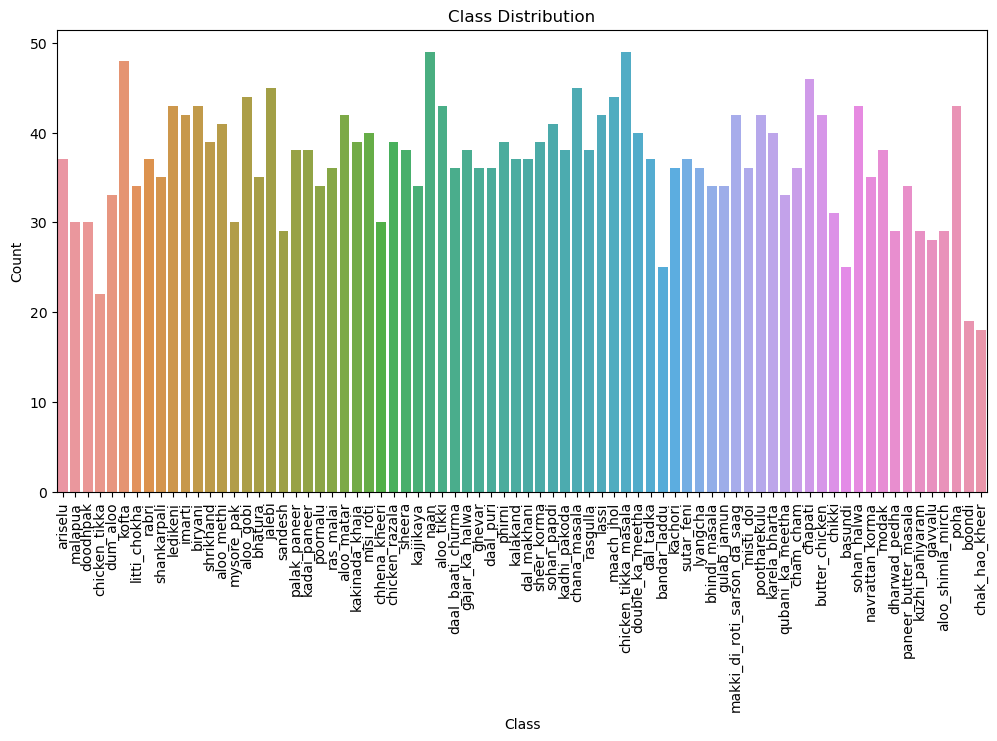

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=image_df, x='Label')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [6]:
# splitting dataset into training and testing data
train_df, test_df = train_test_split(image_df, test_size = 0.20,stratify=image_df['Label'],random_state = 42)

In [7]:
train_df['Label']

1341          sheera
2712    kadai_paneer
326          biryani
1553     sheer_korma
281     palak_paneer
            ...     
1255         kachori
733      sohan_halwa
533           ghevar
757           phirni
276       maach_jhol
Name: Label, Length: 2231, dtype: object

In [8]:
# ImageDataGenerator for training data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    # Rescale pixel values to [0,1] range
    rescale=1./255,
    # Fraction of images reserved for validation (20%)
    validation_split=0.2,
    # Range for random rotations (degrees)
    rotation_range=20,
    # Range for random horizontal shifts
    width_shift_range=0.2,
    # Range for random vertical shifts
    height_shift_range=0.2,
    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=0.2,
    # Range for random zoom
    zoom_range=0.2,
    # Randomly flip inputs horizontally
    horizontal_flip=True,
    # Strategy for filling in newly created pixels after a rotation or a width/height shift
    fill_mode='nearest'
)

# ImageDataGenerator for test data (only rescaling)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [9]:
train_dataset = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    color_mode='rgb',  # RGB color mode
    class_mode='categorical',  # Use categorical labels
    shuffle=True,
    seed=42,
    subset='training'  # Subset for training
)

validation_dataset = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'  # Subset for validation
)

test_dataset = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  # No shuffling for test dataset
)


Found 1785 validated image filenames belonging to 76 classes.
Found 446 validated image filenames belonging to 76 classes.
Found 558 validated image filenames belonging to 76 classes.


In [10]:
# Assuming 'train_gen' is your ImageDataGenerator and 'train_dataset' is your DataFrameIterator
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'aloo_gobi': 0, 'aloo_matar': 1, 'aloo_methi': 2, 'aloo_shimla_mirch': 3, 'aloo_tikki': 4, 'ariselu': 5, 'bandar_laddu': 6, 'basundi': 7, 'bhatura': 8, 'bhindi_masala': 9, 'biryani': 10, 'boondi': 11, 'butter_chicken': 12, 'chak_hao_kheer': 13, 'cham_cham': 14, 'chana_masala': 15, 'chapati': 16, 'chhena_kheeri': 17, 'chicken_razala': 18, 'chicken_tikka': 19, 'chicken_tikka_masala': 20, 'chikki': 21, 'daal_baati_churma': 22, 'daal_puri': 23, 'dal_makhani': 24, 'dal_tadka': 25, 'dharwad_pedha': 26, 'doodhpak': 27, 'double_ka_meetha': 28, 'dum_aloo': 29, 'gajar_ka_halwa': 30, 'gavvalu': 31, 'ghevar': 32, 'gulab_jamun': 33, 'imarti': 34, 'jalebi': 35, 'kachori': 36, 'kadai_paneer': 37, 'kadhi_pakoda': 38, 'kajjikaya': 39, 'kakinada_khaja': 40, 'kalakand': 41, 'karela_bharta': 42, 'kofta': 43, 'kuzhi_paniyaram': 44, 'lassi': 45, 'ledikeni': 46, 'litti_chokha': 47, 'lyangcha': 48, 'maach_jhol': 49, 'makki_di_roti_sarson_da_saag': 50, 'malapua': 51, 'misi_roti': 52, 'misti_doi

In [11]:
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Index to Class Mapping:
{0: 'aloo_gobi', 1: 'aloo_matar', 2: 'aloo_methi', 3: 'aloo_shimla_mirch', 4: 'aloo_tikki', 5: 'ariselu', 6: 'bandar_laddu', 7: 'basundi', 8: 'bhatura', 9: 'bhindi_masala', 10: 'biryani', 11: 'boondi', 12: 'butter_chicken', 13: 'chak_hao_kheer', 14: 'cham_cham', 15: 'chana_masala', 16: 'chapati', 17: 'chhena_kheeri', 18: 'chicken_razala', 19: 'chicken_tikka', 20: 'chicken_tikka_masala', 21: 'chikki', 22: 'daal_baati_churma', 23: 'daal_puri', 24: 'dal_makhani', 25: 'dal_tadka', 26: 'dharwad_pedha', 27: 'doodhpak', 28: 'double_ka_meetha', 29: 'dum_aloo', 30: 'gajar_ka_halwa', 31: 'gavvalu', 32: 'ghevar', 33: 'gulab_jamun', 34: 'imarti', 35: 'jalebi', 36: 'kachori', 37: 'kadai_paneer', 38: 'kadhi_pakoda', 39: 'kajjikaya', 40: 'kakinada_khaja', 41: 'kalakand', 42: 'karela_bharta', 43: 'kofta', 44: 'kuzhi_paniyaram', 45: 'lassi', 46: 'ledikeni', 47: 'litti_chokha', 48: 'lyangcha', 49: 'maach_jhol', 50: 'makki_di_roti_sarson_da_saag', 51: 'malapua', 52: 'misi_roti', 5

In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (excluding the top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Define input and output layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass training=False to ensure correct behavior of BN layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(76, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define batch size
batch_size = 50  # You can adjust this as needed

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with batch size and early stopping
model_history = model.fit(train_dataset, validation_data=validation_dataset, epochs=30, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.0564 - loss: 4.2043 - val_accuracy: 0.1435 - val_loss: 3.4211
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2958 - loss: 2.8319 - val_accuracy: 0.2803 - val_loss: 2.7119
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4388 - loss: 2.0119 - val_accuracy: 0.3655 - val_loss: 2.4582
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5642 - loss: 1.5356 - val_accuracy: 0.3744 - val_loss: 2.4026
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6081 - loss: 1.3153 - val_accuracy: 0.3924 - val_loss: 2.3325
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.7045 - loss: 1.0380 - val_accuracy: 0.4081 - val_loss: 2.2928
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7040 - loss: 0.9780 - val_accuracy: 0.4260 - val_loss: 2.3025
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7853 - loss: 0.7516 - val_accuracy: 0.4484 - val_lo

In [23]:
# saving model in the kaggle/working dir
model.save('model_mobilenetv2.keras')

In [ ]:
# Load the pre-trained VGG19 model (excluding the top)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Create your custom model on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass training=False to ensure correct behavior of BN layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(76, activation='softmax')(x)
# Create the final model
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define batch size
batch_size = 50  # You can adjust this as needed

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_dataset, validation_data = validation_dataset, epochs = 30, batch_size=batch_size, callbacks=[early_stopping])

In [16]:
model.save("model_vgg19.keras")

In [28]:
# Testing saved model
from tensorflow.keras.models import load_model
loaded_model = load_model("model_mobilenetv2.keras")

c:\Users\jvk\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 330 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Text(0.5, 1.0, 'Training and Validation Accuracy')

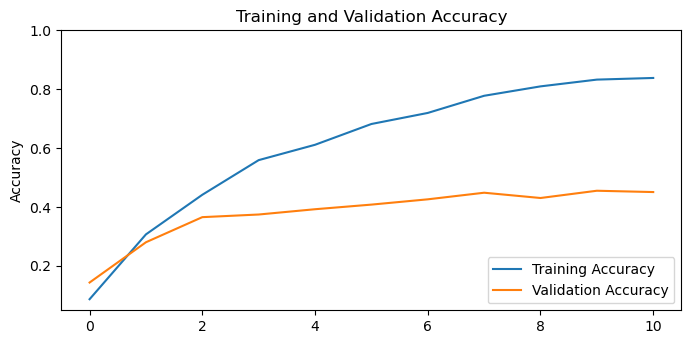

In [29]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

c:\Users\jvk\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 326 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


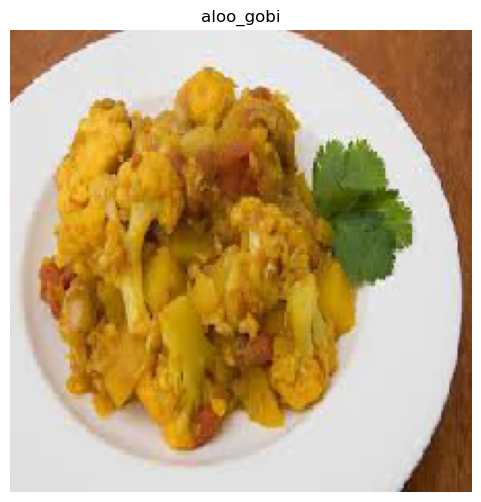

In [31]:
# making prediction using the trained model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from tensorflow.keras.models import load_model

# load model
loaded_model = load_model("model_mobilenetv2_multiclass.keras")

# image
img_path = './Indian Food Images/aloo_gobi/08e086039e.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)

# showing image and prediciton
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(index_to_class[predicted_class_index])
plt.axis('off')
plt.show()

In [18]:
# converting index_to_closs into a pickle file
import pickle

pickle.dump(index_to_class,open('index_to_class.pkl','wb'))